# Association Rules

In [15]:
# Import necessary libraries

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [16]:
# Load the dataset

df0 = pd.read_csv('Online-Retail.csv') 
df0.head(15)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
9,NaN,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047.0,United Kingdom


Since some descriptions represent the same item but have different leading or trailing spaces, they us be made uniform, exploiting the Pandas' function `str.strip()`

In [17]:
print(f"The number of unique Description values in the input file is {len(df0['Description'].unique())}")

The number of unique Description values in the input file is 4224


In [20]:
df1 = df0
df1['Description'] = df0['Description'].str.strip()

In [21]:
print(f"After cleaning, the number of unique Description values in the input file is {len(df1['Description'].unique())}")

After cleaning, the number of unique Description values in the input file is 4212


Some rows might be useless, not having the `InvoiceNo` row. Hence, they must be removed.

In [26]:
print("Rows with missing InvoiceNo before removing:")
df1[df1['InvoiceNo'].isna()] # Only select True rows

Rows with missing InvoiceNo before removing:


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
9,NaN,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047.0,United Kingdom


In [30]:
# Drop the rows with the missing values
df2 = df1.dropna(axis = 0, subset='InvoiceNo')

In [31]:
print("Rows with missing InvoiceNo after removing")
df2[df2['InvoiceNo'].isna()]

Rows with missing InvoiceNo after removing


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


Some InvoiceNo start with a `C`. They are "credit transactions" and must be removed.

In [32]:
print("There are {} rows containing 'C' in 'InvoiceNo'".format(sum(df2['InvoiceNo'].astype(str).str.contains('C'))))

There are 9288 rows containing 'C' in 'InvoiceNo'


In [34]:
# df3 without the InvoiceNo row containing 'C'
df3 = df2[~df2['InvoiceNo'].astype(str).str.contains('C')]

print("After removal, there are {} rows containing 'C' in 'InvoiceNo'"\
      .format(sum(df3['InvoiceNo'].astype('str').str.contains('C'))))

After removal, there are 0 rows containing 'C' in 'InvoiceNo'


Several transactions include the item `'POSTAGE'`, 
which represents the mailing expenses. 
In this analysis we are not interested in it, therefore the rows 
with `'POSTAGE'` will be removed.

In [44]:
target = 'POSTAGE'
column = 'Description'

print(f"There are {sum(df2['Description'].astype('str').str.contains('POSTAGE'))} rows containing {target} in {column}")

There are 1961 rows containing POSTAGE in Description


In [50]:
# Showa short description of the final dataframe

df = df3[~df3['Description'].astype(str).str.contains('POSTAGE')]
df.describe()

,Quantity,UnitPrice,CustomerID
count,530786.000000,530786.000000,396808.000000
mean,10.268044,3.406422,15301.408878
std,159.868423,36.641264,1709.897292
min,-9600.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13975.000000
50%,3.000000,2.080000,15159.000000
75%,10.000000,4.130000,16801.000000
max,80995.000000,13541.330000,18287.000000


After the cleanup, we need to consolidate the items into 1 transaction per row with each product 1 hot encoded. For the sake of keeping the data set small, we are only looking at sales for France. However, in additional code below, we will compare these results to sales from Germany.

In [51]:
basket = (df[df['Country']=='France']
          .groupby(['InvoiceNo', 'Description'])['Quantity']
          .sum().unstack()
          .reset_index().fillna(0).set_index('InvoiceNo'))

basket

Description,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 EGG HOUSE PAINTED WOOD,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,12 PENCILS TALL TUBE POSY,12 PENCILS TALL TUBE RED RETROSPOT,12 PENCILS TALL TUBE WOODLAND,...,WRAP VINTAGE PETALS DESIGN,YELLOW COAT RACK PARIS FASHION,YELLOW GIANT GARDEN THERMOMETER,YELLOW SHARK HELICOPTER,ZINC STAR T-LIGHT HOLDER,ZINC FOLKART SLEIGH BELLS,ZINC HERB GARDEN CONTAINER,ZINC METAL HEART DECORATION,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS SMALL
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536370,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536852,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536974,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
537065,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
537463,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
580986,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
581001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
581171,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


There are a lot of zeros in the data but we also need to make sure any positive values are converted to a 1 and anything less than 0 is set to 0.

In [52]:
# Function which takes a number and returns 0 
# if the number is 0 or less, 1 if the number is 1 or more. 
encode_units = lambda x: 0 if x <= 0 else 1
basket_sets = basket.applymap(encode_units)

Now that the data is structured properly, we can generate frequent item sets that have a support of at least 7% (this number was chosen so that we can get enough useful examples).

In [56]:
frequent_itemsets = apriori(basket_sets, min_support=0.07, use_colnames=True)

# Rules generation
rules = association_rules(frequent_itemsets, metric='lift', min_threshold=1)
rules.shape

(26, 9)

In order to plot the rules, it is better to sort them according to some metrics.
We will sort on descending confidence and support, and plot `'confidence'` and `'support'`.

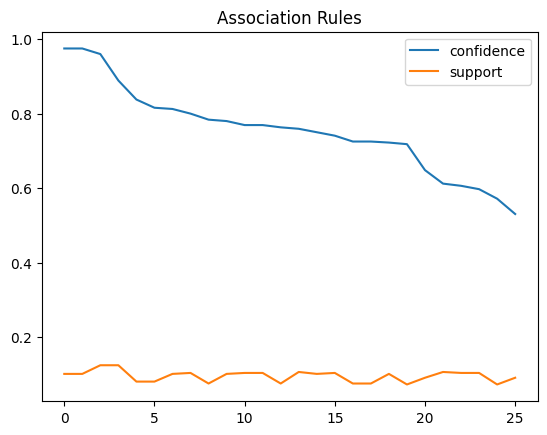

In [57]:
sorted_rules = rules.sort_values(by=['confidence', 'support'], ascending=False).reset_index(drop=True)

sorted_rules[['confidence','support']].plot(title='Association Rules');

You find below a three dimensional plot, where the dot size is proportional to the lift, obtained using `plot.scatter`.

The lift value of an association rule is the ratio of the confidence of the rule and the expected confidence of the rule. The expected confidence of a rule is defined as the product of the support values of the rule body and the rule head divided by the support of the rule body.

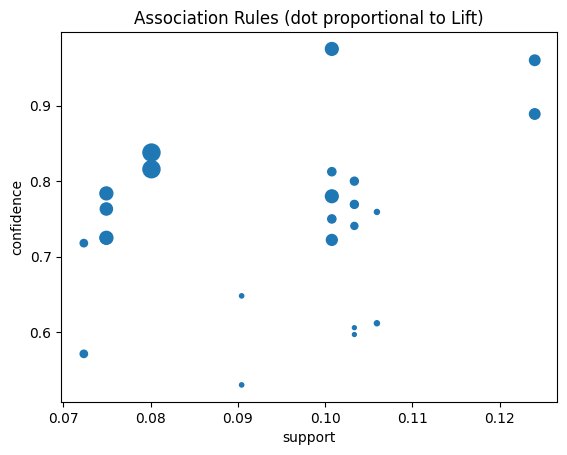

In [58]:
# 1.8 is chosen empirically to obtain the best graphical effect
s = [1.8**n for n in rules.lift]
rules.plot.scatter(x='support', 
                   y='confidence', 
                   title='Association Rules (dot proportional to Lift)', 
                   s=s);

In [59]:
!pip install networkx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Finally, we draw a plot of a subset of the rules using the function `draw_graph`, provided in this package.

In [61]:
from draw_rules_graph import draw_graph
help(draw_graph)

Help on function draw_graph in module draw_rules_graph:

draw_graph(rules, rules_to_show=5)
    draws the rules as a graph linking antecedents and consequents
    "rule nodes" are yellow, with name "R<n>", "item nodes" are green
    arrows colors are different for each rule, and go from the antecedent(s)
    to the rule node and to the consequent(s)
    the "rules_to_show" parameter limits the rules to show to the initial
    part of the "rules" dataframe



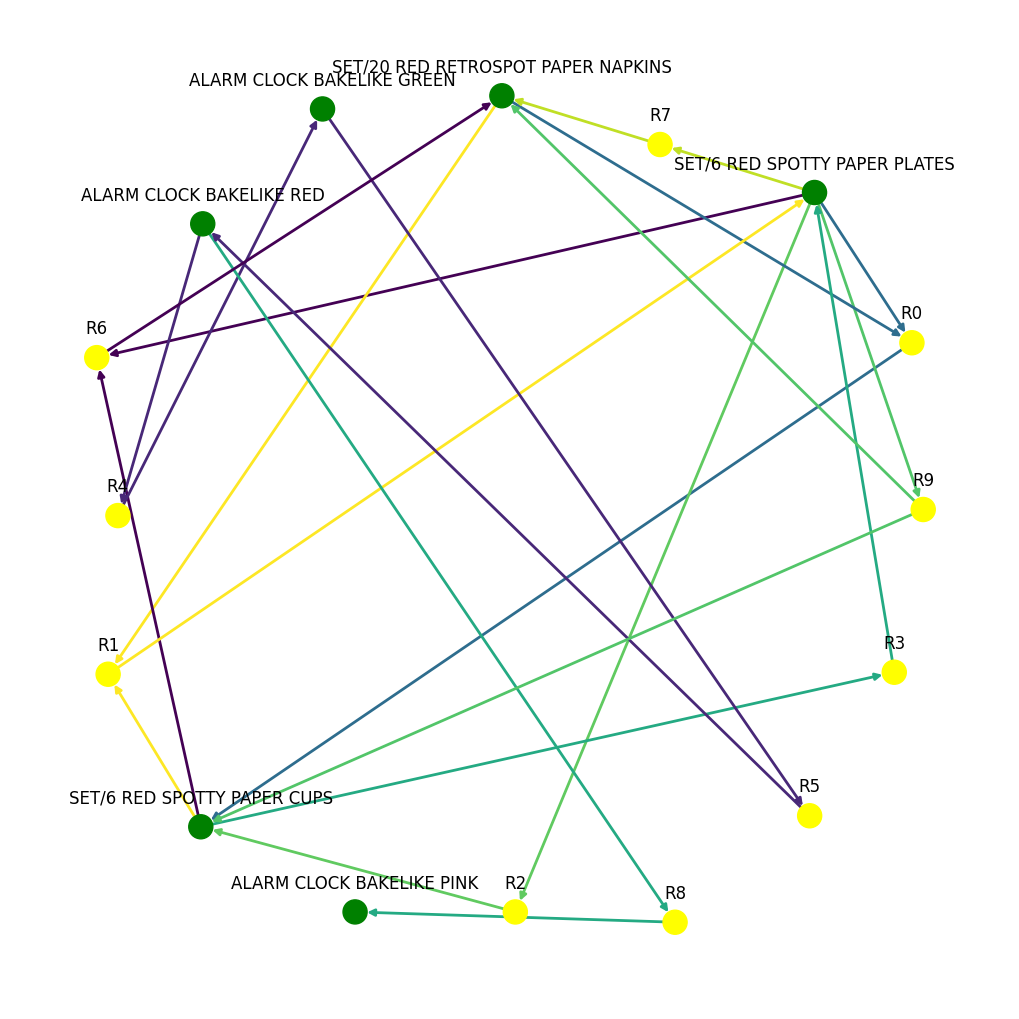

In [62]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,10))
draw_graph (sorted_rules, 10)  